# Predicting Cancer Status in the "Breast Cancer Wisconsin" Data Set

The Breast Cancer Wisconsin Data set consists of 699 samples of tissue collected between 1989-1991 donated by Dr. Wolberg, a medical doctor involved in cancer research.

For each sample, nine features were collected, as well as the diagnosis of **benign** vs. **cancer** (approximately 2/3 benign, 1/3 cancerous).

In this notebook I conduct some basic exploration of this data set and fit a predictive model based on a decision tree (and the ensemble version, random forests) for the classification task of predicting the traget (cancer) from the feature measurements. I use **10-fold cross validation** to estimate the performance of the fitted models.

Some takeaways are that:
1. Many of the features collected historically are individually strong indicators of the target (cancer), but many pairs of features are highly correlated with each other.

2. **Recall is our top priority** because false negatives when cancer is present should be reduced as much as possible. A simple **decision tree of depth 3** provides highly-accurate predictions (mean of 0.96) with remarkably-high mean recall of 0.99. 

3. By pruning the decision tree to depth 3, I give a model that **avoids overfitting and is highly interpretable** (e.g. by medical professionals). Since the tree splits on only a subset of the features, my analysis suggests that a smaller set of measurements (compared to the existing feature set) may be sufficient to perform reliable diagnosis in the future. If measurement of some of the current features is expensive or time consuming, **a decision-tree approach could allow relatively-inexpensive but simultaneously highly-reliable cancer diagnoses** compared with models that depend on a larger subset of the features.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

%matplotlib inline


# 1. code number            id number
# 2. Clump Thickness               1 - 10
# 3. Uniformity of Cell Size       1 - 10
# 4. Uniformity of Cell Shape      1 - 10
# 5. Marginal Adhesion             1 - 10
# 6. Single Epithelial Cell Size   1 - 10
# 7. Bare Nuclei                   1 - 10
# 8. Bland Chromatin               1 - 10
# 9. Normal Nucleoli               1 - 10
# 10. Mitoses                       1 - 10
# 11. Class:   2 for benign, 4 for cancer


breast_cancer = pd.read_csv('breast_cancer.txt', header = None, 
names = ['code','clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bn','bc','nn','mit','class'])

In [75]:
breast_cancer['class'].value_counts()
#Not so imbalanced

2    458
4    241
Name: class, dtype: int64

In [76]:
breast_cancer.head()

,code,clump_thickness,unif_cell_size,unif_cell_shape,adhesion,epi_cell_size,bn,bc,nn,mit,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Exploratory Data Analysis

Since there are so few features, let's do a quick spot check about whether any of the features individually appear to be very strong indicators of the target (cancer). 

Because the features are discrete-valued (integers, rather than real-valued), we'll first randomly "jitter" the feature and target coordinates to produce a graphic that resembles a simple density plot.

In [77]:
jittered_values = []

for index in list(range(len(breast_cancer))):
    jittered_values.append( breast_cancer['class'][index]+ np.random.uniform(0, 1.5))
    
def jitter_data(series):
    jittered = []
    for index in list(range(len(series))):
        jittered.append(series[index]+ np.random.uniform(-.25, 0.5))
    return jittered

In [78]:
breast_cancer['jitter_class'] = jittered_values

Text(0, 0.5, 'Benign       VS.       Cancer')

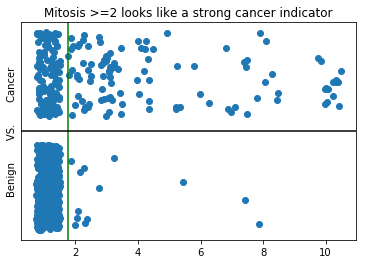

In [79]:
#for feature in list(breast_cancer.keys()):

plt.plot(jitter_data(breast_cancer['mit']), breast_cancer['jitter_class'], 'o')
plt.title('Mitosis >=2 looks like a strong cancer indicator')
plt.axvline(x = 1.75,color ='g')
plt.axhline(y = 3.75,color ='black')
plt.yticks([])
plt.ylabel('Benign       VS.       Cancer')

#mit_bi = []
#for index in list(range(len(breast_cancer))):
#    mit_bi.append(int(breast_cancer['mit'][index]>=3))

Observe in the previous figure that, *conditioned on the Mitosis feature taking value greater than or equal to 2, the probability the sample is diagnosed as "cancer" rises dramatically.* This corresponds to the data that falls to the right of the green vertical divider.

Let's check whether similar thresholds appear to exist for the other features.

Text(0, 0.5, 'Benign       VS.       Cancer')

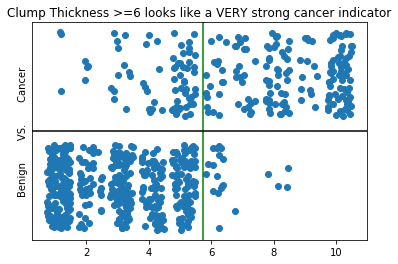

In [80]:
plt.plot(jitter_data(breast_cancer['clump_thickness']), breast_cancer['jitter_class'], 'o')
plt.title('Clump Thickness >=6 looks like a VERY strong cancer indicator')
plt.axvline(x = 5.75,color ='g')
plt.axhline(y = 3.75,color ='black')
plt.yticks([])
plt.ylabel('Benign       VS.       Cancer')


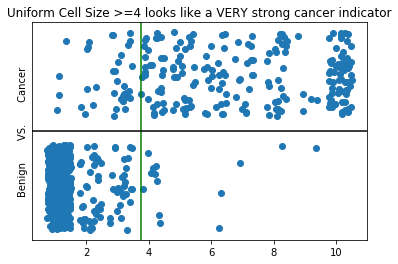

In [81]:
plt.plot(jitter_data(breast_cancer['unif_cell_size']), breast_cancer['jitter_class'], 'o')
plt.title('Uniform Cell Size >=4 looks like a VERY strong cancer indicator')
plt.axvline(x = 3.75,color ='g')
plt.axhline(y = 3.75,color ='black')

plt.yticks([])
plt.ylabel('Benign       VS.       Cancer')

plt.savefig("Sample_Expl_Data_Vis_2.pdf")

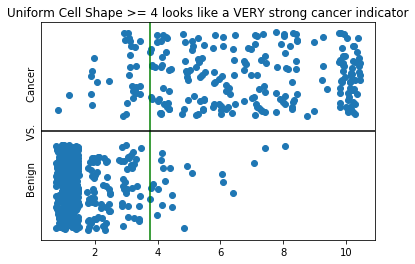

In [82]:
plt.plot(jitter_data(breast_cancer['unif_cell_shape']), breast_cancer['jitter_class'], 'o')
plt.title('Uniform Cell Shape >= 4 looks like a VERY strong cancer indicator')

plt.axvline(x = 3.75,color ='g')
plt.axhline(y = 3.75,color ='black')

plt.yticks([])
plt.ylabel('Benign       VS.       Cancer')

plt.savefig("Sample_Expl_Data_Vis.pdf")

Text(0, 0.5, 'Benign       VS.       Cancer')

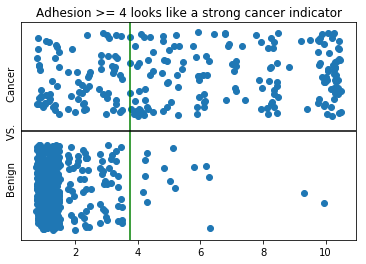

In [83]:
plt.plot(jitter_data(breast_cancer['adhesion']), breast_cancer['jitter_class'], 'o')
plt.title('Adhesion >= 4 looks like a strong cancer indicator')

plt.axvline(x = 3.75,color ='g')
plt.axhline(y = 3.75,color ='black')

plt.yticks([])
plt.ylabel('Benign       VS.       Cancer')

Text(0, 0.5, 'Benign       VS.       Cancer')

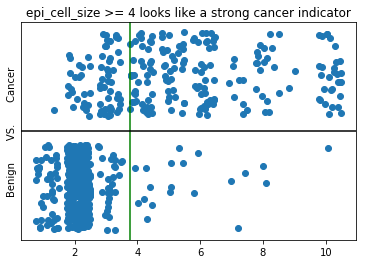

In [84]:
plt.plot(jitter_data(breast_cancer['epi_cell_size']), breast_cancer['jitter_class'], 'o')
plt.title('epi_cell_size >= 4 looks like a strong cancer indicator')

plt.axvline(x = 3.75,color ='g')
plt.axhline(y = 3.75,color ='black')

plt.yticks([])
plt.ylabel('Benign       VS.       Cancer')

Text(0, 0.5, 'Benign       VS.       Cancer')

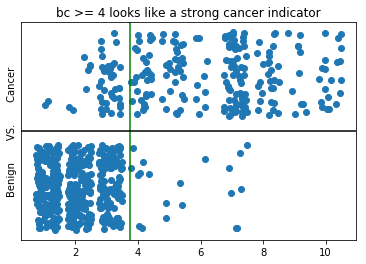

In [85]:
plt.plot(jitter_data(breast_cancer['bc']), breast_cancer['jitter_class'], 'o')
plt.title('bc >= 4 looks like a strong cancer indicator')

plt.axvline(x = 3.75,color ='g')
plt.axhline(y = 3.75,color ='black')

plt.yticks([])
plt.ylabel('Benign       VS.       Cancer')

Text(0, 0.5, 'Benign       VS.       Cancer')

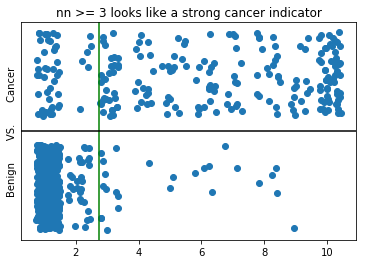

In [86]:
plt.plot(jitter_data(breast_cancer['nn']), breast_cancer['jitter_class'], 'o')
plt.title('nn >= 3 looks like a strong cancer indicator')

plt.axvline(x = 2.75,color ='g')
plt.axhline(y = 3.75,color ='black')

plt.yticks([])
plt.ylabel('Benign       VS.       Cancer')



In [87]:
natural_labels = []

for index in list(range(len(breast_cancer))):
    natural_labels.append(int((breast_cancer['class'][index]-2)/2))
    
breast_cancer['target'] = natural_labels


Many features appear to individually provide strong evidence about the target. The similarity of the plots above does suggest that some pairs of features may be highly correlated. Before proceeding, we will quickly check a correlation matrix of the features. 

Text(0.5, 1.0, 'Correlation Between Features')

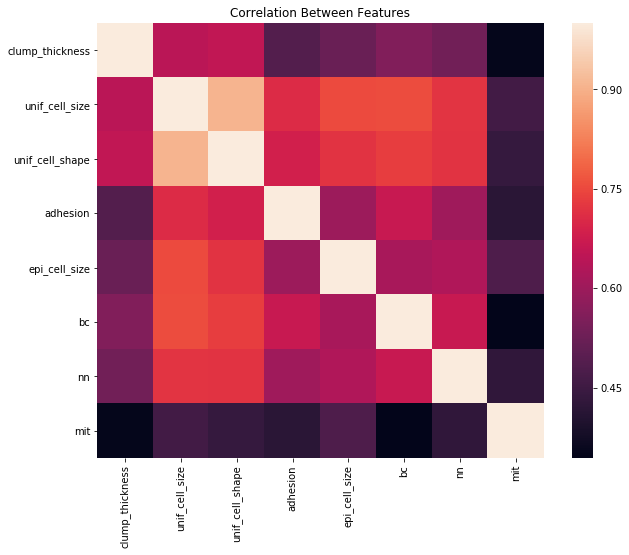

In [88]:
import seaborn as sns

features_breast_cancer = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit']]

plt.rcParams["figure.figsize"] = (10,8)
corr = features_breast_cancer.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.title('Correlation Between Features')

## Fitting a Model: Simple Decision Tree

**On an individual basis, many features appear very promising in their ability to predict the "cancer" label.** 

In particular, for most features there seems to be a **binary split of the range** such features might take, e.g. *"Given that adhesion is at least 4 the conditional probability of cancer is much higher than the probability of cancer in the broader data set."*

Based on this EDA, we consider a **decision tree to be a promising model**. We are hopeful that the predictive power that we observed individually for the various features does not prove to be completely colinear (that is, after splitting on one feature, we hope to find that subsequent splits on other features will continue to reduce the gini impurity). Even though we have observed high correlation between certain pairs of features, we proceed with the full set of features for now.

First, since we have a 2-to-1 imbalance between our class labels, and decision tree models can be biased when trained on imbalanced data, we'll **upsample the cancer-labeled samples**.

To **avoid overfitting**, we will restrict splitting of internal nodes that contain too few samples, and we will require each leaf to contain at least a certain number of samples. Also, we will limit the depth of the tree (to focus on the most substantial splits near the root).

In [89]:
# Upsampling to balance the labels:

# We'll up-sample with replacement from the set of 
# positive (cancer) examples in order to obtain 
# a balanced set to train on.

breast_cancer = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit','target']]

up_breast_cancer = breast_cancer

neg_examples = list(breast_cancer['target'].value_counts())[0]
pos_examples = list(breast_cancer['target'].value_counts())[1]

samples_to_add = neg_examples - pos_examples

for index in range(samples_to_add):
    one_sample = breast_cancer[breast_cancer.target == 1].sample(1)
    frames = [up_breast_cancer, one_sample]
    up_breast_cancer = pd.concat(frames)
    
up_breast_cancer['target'].value_counts()

breast_cancer = up_breast_cancer

# By the way, this label balancing increased every performance metric and 
# dramatically reduced the variation that we were seeing in cross-validation tests



In [90]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit']]
Y = breast_cancer['target']

clf = tree.DecisionTreeClassifier(criterion='gini',max_depth=3, min_samples_split=12, min_samples_leaf=5)

#clf = clf.fit(X, Y)


In [91]:
scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
#print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='precision')
#print(scores)

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
#print(scores)

print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.95 (+/- 0.06)
   
Precision: 0.93 (+/- 0.10)
   
Recall: 0.98 (+/- 0.03)


A simple decision-tree classifier delivers **high accuracy for this classification problem.** 

By using **10-fold cross-validation**, we have confidence that the accuracy range we observe is generalizable and not highly dependent on the precise specification of a particular test set (namely, we haven't leaked too much information about a fixed test set through some exploration of the hyperparamters we introduced - min number of samples for splitting, max tree depth, etc).

Now let's **visualize the trained classifier** (here we will train on all available data).

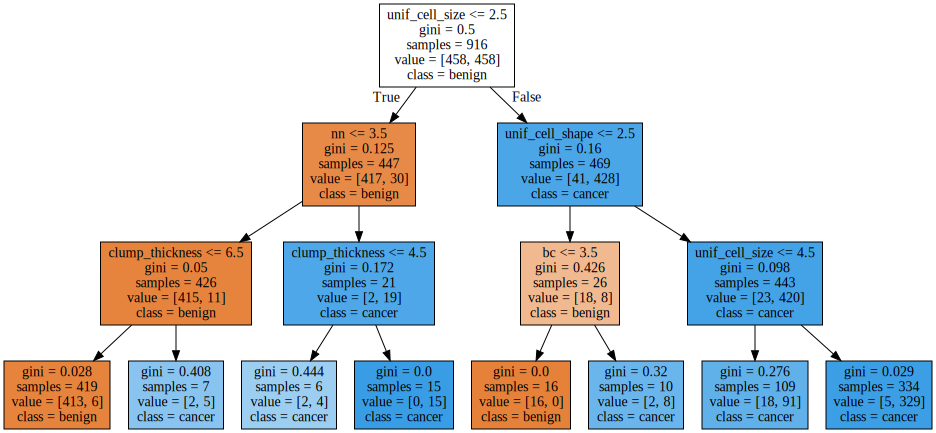

In [92]:
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display


clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=12, min_samples_leaf=5)
clf = clf.fit(X, Y)

labels = X.keys()

graph = Source(tree.export_graphviz(clf, out_file=None
   , feature_names=labels, class_names=['benign', 'cancer'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))


**Discussion:** We notice immediately that several of the **features that we flagged in our exploratory analysis** appear high in the tree (chosen early in the splitting process because they deliver large reductions in the gini impurity). By limiting the depth of the tree, we highlight several highly-predictive features. Notably, this decision tree uses only 4 features from the original set (uniform cell size, uniform cell shape, clump thickness and bland chromatim).

**Most leaves that contain substantial numbers of samples have low gini impurity** with one notable exception (a leaf near the lower left with gini impurity of about 25% and 115 samples). Though our approach of limiting the tree depth appears to have been a great overall choice, we might consider allowing one addional split for this particular leaf (in case any of the reamining features, or even refinements of the splits on uniform cell size or uniform cell shape) can separate many of the benign samples from the 97 cancer samples.

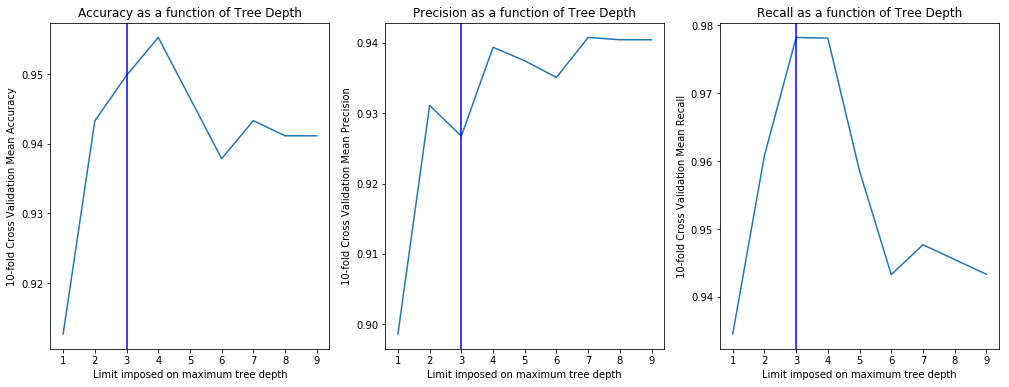

In [93]:
# Let's check whether our limit of 3 on the depth of the tree seems to have done anything....

X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit']]
Y = breast_cancer['target']

tree_depth_limit = []
tree_cv_accuracy = []
tree_cv_precision = []
tree_cv_recall = []


for depth_limit in list(range(1,10)):
    tree_depth_limit.append(depth_limit)
    clf = tree.DecisionTreeClassifier(criterion='gini',max_depth=depth_limit, min_samples_split=12, min_samples_leaf=5)
    
    scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
    tree_cv_accuracy.append(scores.mean())
    
    scores = cross_val_score(clf, X, Y, cv=10,scoring ='precision')
    tree_cv_precision.append(scores.mean())
    
    scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
    tree_cv_recall.append(scores.mean())

plt.rcParams["figure.figsize"] = (17,6)
plt.subplot(131)
plt.plot(tree_depth_limit,tree_cv_accuracy)
plt.title('Accuracy as a function of Tree Depth')
plt.xlabel('Limit imposed on maximum tree depth')
plt.ylabel('10-fold Cross Validation Mean Accuracy')
plt.axvline(x = 3,color ='b')

plt.subplot(132)
plt.plot(tree_depth_limit,tree_cv_precision)
plt.title('Precision as a function of Tree Depth')
plt.xlabel('Limit imposed on maximum tree depth')
plt.ylabel('10-fold Cross Validation Mean Precision')
plt.axvline(x = 3,color ='b')

plt.subplot(133)
plt.plot(tree_depth_limit,tree_cv_recall)
plt.title('Recall as a function of Tree Depth')
plt.xlabel('Limit imposed on maximum tree depth')
plt.ylabel('10-fold Cross Validation Mean Recall')
plt.axvline(x = 3,color ='b')

plt.savefig("Sample_Expl_Data_Vis_4.pdf")

While precision can continue to rise if we allow the depth of the decision tree to increase, we observe a simultaneous decline in recall, such that **overall accuracy improves minimally for tree depths above 3.** When accuracy improvements fall within the margin of error (what is observed here), we prefer a shallower tree that is easier to interpret and highlights the most useful indicators of the target. 

Having conducted this exploration, we are satisfied with our choice of pruning (to depth 3) for the simple decision tree. Investigation of similar graphs where cross-validation metrics are plotted as a function of the limit we imposed on the number of samples in internal tree nodes (aka, nodes that are split), shows very low-magnitude changes across a range of possibilities between 2 and 15. Once we have controlled for tree depth, the effect of manipulating this constraint is limited (probably because, organically, few high-ly useful very small splits arise in such a shallow tree).

Note that since 10-fold cross-validation is a randomized procedure the precise graphs observed above will vary.


## Move to an Ensemble Method: Random Forest Classifier

While we are relatively happy with the mean Accuracy, Precision and Recall delivered by our simple decision tree in cross-validation, let's see if we can achieve more robust performance by moving to an estimator defined by an **ensemble of trees, aka a Random Forest classifer.**

In [94]:
from  sklearn.ensemble import RandomForestClassifier

X = breast_cancer[['clump_thickness', 'unif_cell_size','unif_cell_shape', 'adhesion', 'epi_cell_size','bc','nn','mit']]
Y = breast_cancer['target']

clf = RandomForestClassifier(n_estimators = 50,criterion='gini', max_depth=3, min_samples_split=12, min_samples_leaf=5)


In [95]:
scores = cross_val_score(clf, X, Y, cv=10,scoring ='accuracy')
#print(scores)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='precision')
#print(scores)

print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("   ")

scores = cross_val_score(clf, X, Y, cv=10,scoring ='recall')
#print(scores)

print("Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.96 (+/- 0.05)
   
Precision: 0.95 (+/- 0.07)
   
Recall: 0.98 (+/- 0.03)


Nice! Even though there was not much room for improvement, our shift to an ensemble of decision trees appears to have slightly boosted our cross validation metrics.

However, **since the simple decision tree method is so competitive and more interpretable**, in most contexts we might prefer to present it, particularly in conversations with medical professionals about key signals that might be measured and predictive in advance of a formal diagnosis.





In [96]:
# Appendix

#ROC Curve for a single decision tree

#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

#clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_split=12, min_samples_leaf=5)
#clf = clf.fit(X_train, y_train)

#predicted_probas = clf.predict_proba(X_test)

#plt.rcParams["figure.figsize"] = (10, 10)
#import matplotlib.pyplot as plt
#import scikitplot as skplt
#skplt.metrics.plot_roc(y_test, predicted_probas)
#plt.show()